## Hugo's Individual Project 3

### 0. Setup Credentials

In [0]:
# Read the contents of credentials.env
file_path = "credentials.env"  # Replace with the actual path
with open(file_path, "r") as file:
    credentials_content = file.read()

# Parse the content of credentials.env and set environment variables
for line in credentials_content.split("\n"):
    if "=" in line:
        key, value = line.split("=", 1)
        os.environ[key.strip()] = value.strip()


### 1. Extract Data

In [0]:
!python extract_data.py

Getting file: dbfs:/FileStore/HugoHu_Project_3/shopping_trends.csv
File dbfs:/FileStore/HugoHu_Project_3/shopping_trends.csv uploaded successfully.


### 2. Transform Data

In [0]:
# The Spark has problem running in individual file, so I put the code here.

"""
transform and load function
"""

from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Read CSV").master("local").getOrCreate()

def load(dataset="dbfs:/FileStore/HugoHu_Project_3/shopping_trends.csv"):
    # Remove the SparkSession creation
    # spark = SparkSession.builder.appName("Read CSV").getOrCreate()
    
    # Access the SparkSession from the Databricks environment
    

    shopping_trends_df = spark.read.csv(dataset, header=True, inferSchema=True)

    # Clean up column names by replacing spaces with underscores
    for col in shopping_trends_df.columns:
        new_col = col.replace(" ", "_").replace("-", "_").replace(".", "_").replace("\n", "_").replace("\t", "_").replace("(", "_").replace(")", "_").replace("{", "_").replace("}", "_").replace("=", "_")
        shopping_trends_df = shopping_trends_df.withColumnRenamed(col, new_col)

    shopping_trends_df = shopping_trends_df.withColumn("id", monotonically_increasing_id())

    # transform into a delta lakes table and store it 
    shopping_trends_df.write.format("delta").mode("overwrite").saveAsTable("shopping_trends")
    
    num_rows = shopping_trends_df.count()
    print(num_rows)
    
    return "finished transform and load"

if __name__ == "__main__":
    load()


3900


### 3. Visualize Data

Data validation passed. 40 rows available.


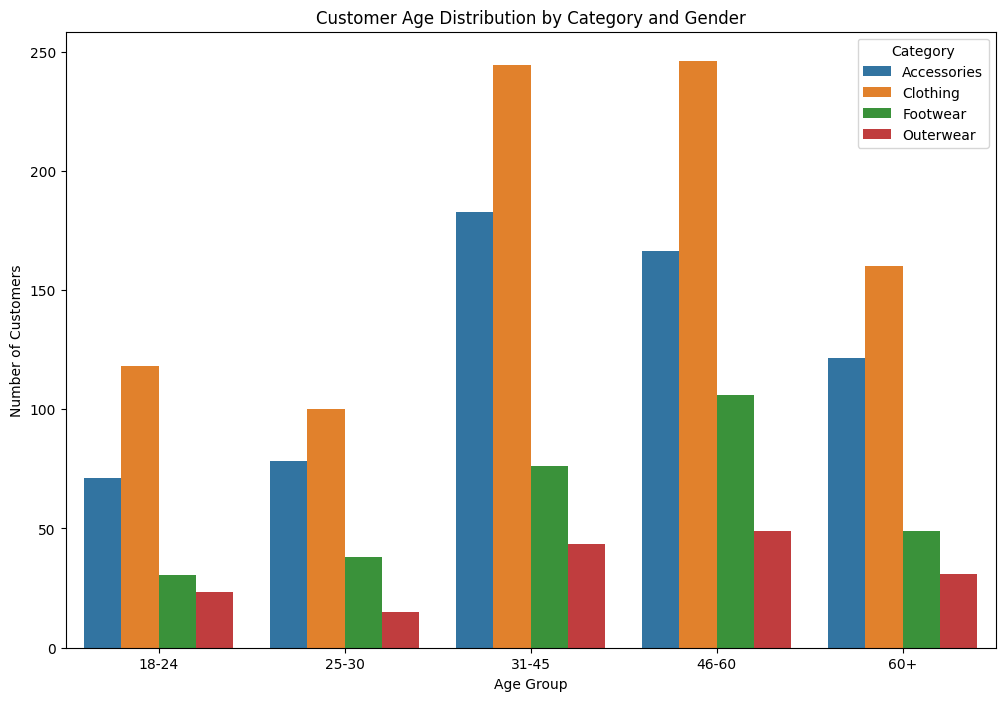

Data validation passed. 199 rows available.


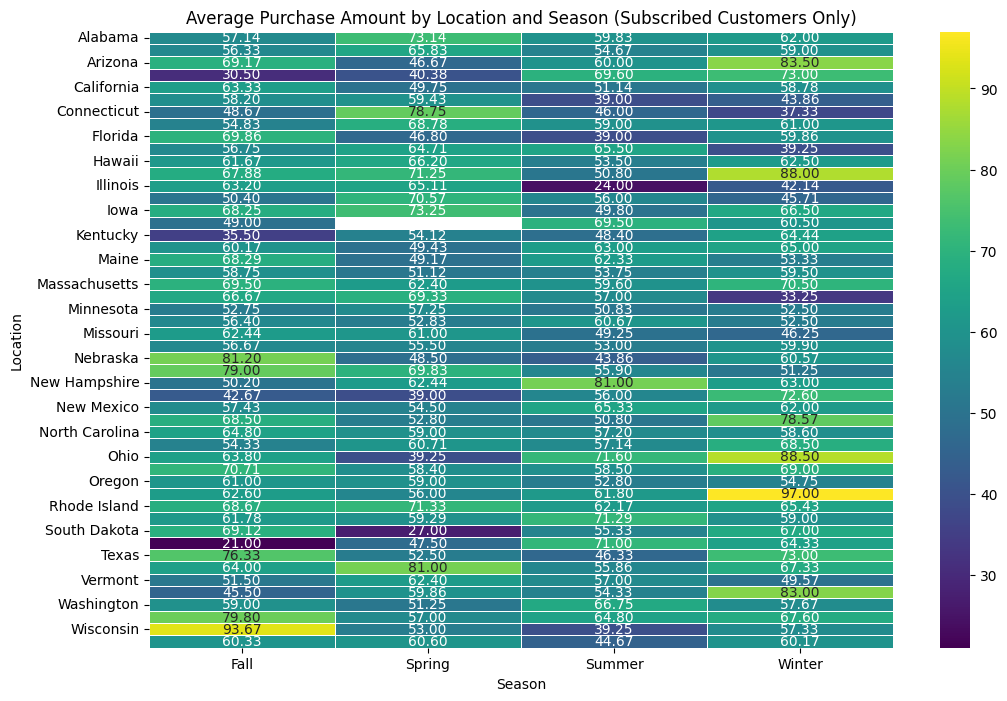

Data validation passed. 200 rows available.


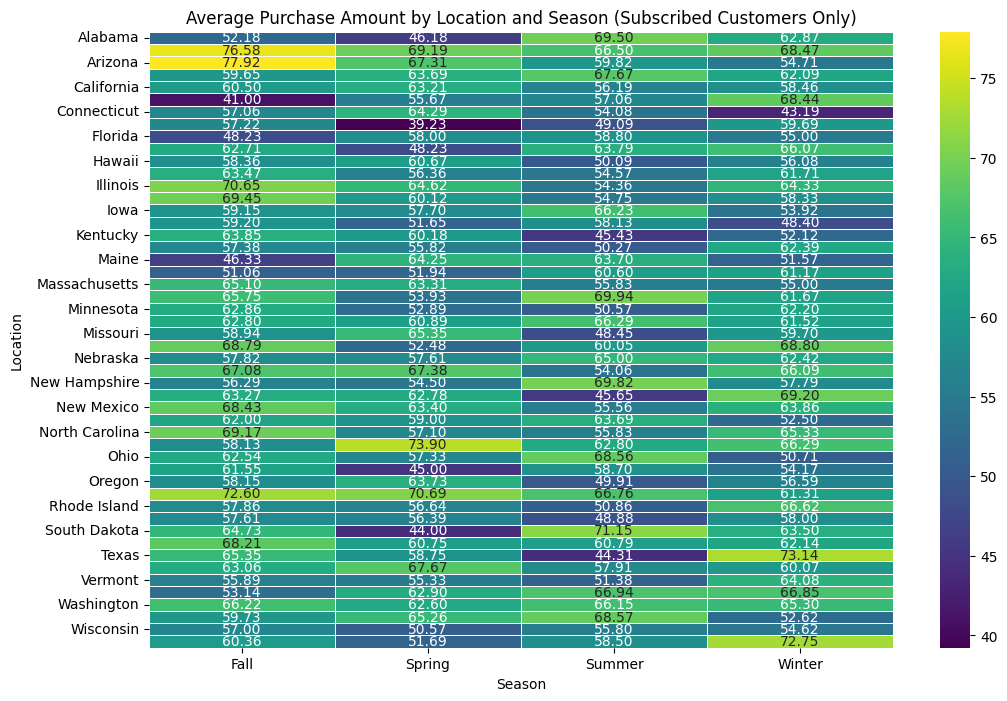

In [0]:
"""
query and visualize data
"""

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def query_transform1():
    spark = SparkSession.builder.appName("Query").getOrCreate()
    query = (
        "SELECT"
        "    CASE"
        "        WHEN Age BETWEEN 0 AND 17 THEN '18-'"
        "        WHEN Age BETWEEN 18 AND 24 THEN '18-24'"
        "        WHEN Age BETWEEN 25 AND 30 THEN '25-30'"
        "        WHEN Age BETWEEN 31 AND 45 THEN '31-45'"
        "        WHEN Age BETWEEN 46 AND 60 THEN '46-60'"
        "        ELSE '60+'"
        "    END AS AgeGroup,"
        "    Gender,"
        "    Category,"
        "    COUNT(*) AS NumberOfCustomers"
        " FROM shopping_trends"
        " GROUP BY AgeGroup, Gender, Category"
        " ORDER BY AgeGroup, Gender, Category;"
    )
    query_result = spark.sql(query)
    return query_result

def query_transform2():
    spark = SparkSession.builder.appName("Query").getOrCreate()
    query = (
        "SELECT"
        "    Location,"
        "    Season,"
        "    AVG(Purchase_Amount__USD_) AS AvgPurchaseAmount"
        " FROM shopping_trends"
        " WHERE Subscription_Status = 'Yes'"
        " GROUP BY Location, Season"
        " ORDER BY Location, Season;"
        )
    query_result = spark.sql(query)
    return query_result


def query_transform3():
    spark = SparkSession.builder.appName("Query").getOrCreate()
    query = (
        "SELECT"
        "    Location,"
        "    Season,"
        "    AVG(Purchase_Amount__USD_) AS AvgPurchaseAmount"
        " FROM shopping_trends"
        " WHERE Subscription_Status = 'No'"
        " GROUP BY Location, Season"
        " ORDER BY Location, Season;"
    )
    query_result = spark.sql(query)
    return query_result


def plot_age_distribution():
    df = query_transform1().toPandas()
    if len(df) > 0:
        print(f"Data validation passed. {len(df)} rows available.")
    else:
        print("No data available. Please investigate.")
    # Plotting
    plt.figure(figsize=(12, 8))
    sns.barplot(x='AgeGroup', y='NumberOfCustomers', hue='Category', data=df, errorbar=None)
    plt.title('Customer Age Distribution by Category and Gender')
    plt.xlabel('Age Group')
    plt.ylabel('Number of Customers')
    plt.show()


def plot_purchase_by_sub():
    df = query_transform2().toPandas()
    if len(df) > 0:
        print(f"Data validation passed. {len(df)} rows available.")
    else:
        print("No data available. Please investigate.")

    # Pivot the DataFrame for better visualization
    pivot_df_subscribed = df.pivot_table(index='Location', columns='Season', values='AvgPurchaseAmount', aggfunc='mean')

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df_subscribed, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
    plt.title('Average Purchase Amount by Location and Season (Subscribed Customers Only)')
    plt.xlabel('Season')
    plt.ylabel('Location')
    plt.show()


def plot_purchase_by_not_sub():
    df = query_transform3().toPandas()
    if len(df) > 0:
        print(f"Data validation passed. {len(df)} rows available.")
    else:
        print("No data available. Please investigate.")

    # Pivot the DataFrame for better visualization
    pivot_df_subscribed = df.pivot_table(index='Location', columns='Season', values='AvgPurchaseAmount', aggfunc='mean')

    # Plotting
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_df_subscribed, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
    plt.title('Average Purchase Amount by Location and Season (Subscribed Customers Only)')
    plt.xlabel('Season')
    plt.ylabel('Location')
    plt.show()

if __name__ == "__main__":
    plot_age_distribution()
    plot_purchase_by_sub()
    plot_purchase_by_not_sub()



